In [1]:
import sys
sys.path.append("../dependencies/geometric-algebra-transformer")
sys.path.append("..")

import json
from pathlib import Path

import torch
import torch.nn as nn
from pytorch3d.utils import ico_sphere

from pytorch3d.transforms import random_rotation, matrix_to_quaternion
from pytorch3d.loss import chamfer_distance

from src.dataloader import Pix3DObject
from src.model_gatr import Img2PCModelConfig, Img2PCModel
from src.visualization import plot_normalized_point_cloud

In [2]:
with open("../data/raw/pix3d.json") as f:
    index = json.load(f)

In [18]:
obj = Pix3DObject(Path("../data/raw").resolve(), index[0])
pc = obj.sample_points(to_pga=False)

<Axes3D: xlabel='x', ylabel='y', zlabel='z'>

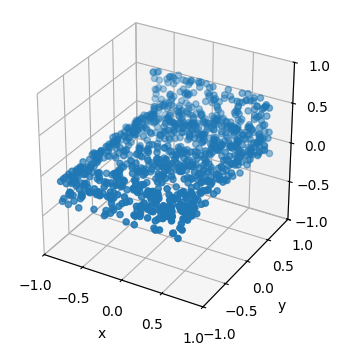

In [19]:
plot_normalized_point_cloud(pc[..., [0, 2, 1]])

In [ ]:
noise = torch.randn((8, 512, 1, 16), device="cuda")
vision_embedding = torch.randn((8, 16, 768), device="cuda")

In [ ]:
cfg = Img2PCModelConfig()
net = Img2PCModel(cfg).to("cuda")

In [ ]:
pc = net(noise, vision_embedding)
pc.shape